In [1]:
# 先知晓一下当前的目录地址
!pwd

/mnt/e/文件/太极实验室科创计划/任务1


In [2]:
# 安装必要的程序包
!pip install --upgrade lalsuite -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
# https://git.ligo.org/lscsoft/lalsuite/-/issues/300
import lal
lal.__version__

/tmp/ipykernel_26855/1428922197.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


'7.5.0'

In [4]:
import torch
torch.__version__

'2.2.2+cu121'

# PyTorch深度学习框架

PyTorch是一个开源的深度学习框架，由Facebook的人工智能研究团队开发。它提供了两个高级功能：

1. 强大的GPU加速的张量计算（如NumPy）库。
2. 包含自动微分系统的深度神经网络。

PyTorch的设计哲学是“尽可能地保持用户对过程的控制，而不是隐藏复杂的细节”。

这使得PyTorch在研究和开发新的深度学习模型时非常灵活，因为用户可以看到并控制模型的内部操作。

- 这部分代码主要是引入所需要的库

In [5]:
# 把脚本里的所有关联的程序包、类、函数都 load 一下
from main import *
from utils import *

## Train

这段代码是一个使用PyTorch进行二分类任务的例子，任务是通过引力波数据（噪声+信号）来进行分类。

首先，我们创建了一个数据生成器DatasetGenerator，它用于生成训练和测试数据集。每个epoch的样本数为100，信噪比为20。

然后，我们使用PyTorch的DataLoader创建了训练和测试数据加载器，批处理大小为32，数据在每个epoch后都会被打乱。

接着，我们加载了预训练的模型，如果没有预训练的模型，就会初始化一个新的模型。模型和损失历史的输出路径为./checkpoints_cnn/。

然后，我们设置了优化器的参数，学习率为0.003，总的训练轮数为100，如果有预训练的模型，训练轮数会加上已经训练过的轮数。

最后，我们调用train函数开始训练模型。训练过程中，模型会在每个epoch后在测试集上进行评估，并保存测试损失最小的模型。

loss 0.0005, train acc 1.000, test acc 0.990
349.7 examples/sec on cuda


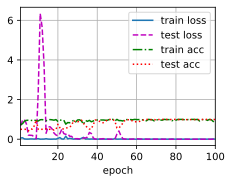

In [6]:
# 初始化数据生成 class
nsample_perepoch = 100  # 每个epoch的样本数
dataset_train = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 训练数据集
dataset_test = DatasetGenerator(snr=20, nsample_perepoch=nsample_perepoch)  # 测试数据集

# 创建一个DataLoader
data_loader = DataLoader(dataset_train, batch_size=32, shuffle=True,)  # 训练数据加载器
test_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)  # 测试数据加载器

device = torch.device('cuda')  # 使用CUDA设备

# 模型和损失历史的输出路径
checkpoint_dir = './checkpoints_cnn/'

# 创建模型    
net, epoch, train_loss_history = load_model(checkpoint_dir)  # 加载模型
net.to(device);  # 将模型转移到设备上

# 优化器参数
lr = 0.003  # 学习率
total_epochs = 100  # 总的训练轮数
total_epochs += epoch  # 加上已经训练过的轮数
output_freq = 1  # 输出频率

# 训练模型
train(net, lr, nsample_perepoch, epoch, total_epochs,
      dataset_train, data_loader, test_iter,
      train_loss_history, checkpoint_dir, device, notebook=True)

In [7]:
dataset_train.strains.shape

(100, 1, 2, 16384)

## Evaluate

这段代码定义了一个函数evaluate_gpu，用于在GPU上计算模型在数据集上的预测结果。

首先，我们检查输入的模型net是否是nn.Module的实例。如果是，我们将模型设置为评估模式，并获取模型的设备。如果用户没有指定设备，我们将使用模型的第一个参数所在的设备。

然后，我们定义了一个softmax函数，用于将模型的输出转换为概率。

接着，我们创建了两个空列表y_hat_list和y_list，用于存储模型的预测结果和真实标签。

然后，我们进入一个无需计算梯度的环境中，遍历数据加载器data_iter中的所有批次。对于每个批次，我们将数据和标签转移到设备上，并转换为适当的数据类型。然后，我们将数据通过模型进行前向传播，得到预测结果。

接着，我们将预测结果通过softmax函数转换为概率，并将其转移到CPU上，然后转换为NumPy数组，取出正类的概率，并转换为列表。我们也将标签转移到CPU上，然后转换为NumPy数组，并转换为列表。

最后，我们将预测结果和标签添加到y_hat_list和y_list中，并在遍历完所有批次后，将这两个列表转换为NumPy数组并返回。

这个函数可以用于在训练过程中的每个epoch后，或者在训练完成后，评估模型在验证集或测试集上的性能。

In [8]:
# 加载必要的库
import lal  # https://git.ligo.org/lscsoft/lalsuite/-/issues/300
from main import *
from utils import *
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    y_list = []  # 初始化标签列表
    with torch.no_grad():  # 不进行梯度计算
        for X, y in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y = y.to(device).to(torch.long)  # 将标签转移到设备上并转换为长整型
            y_hat = net(X)  # 使用模型进行预测

            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            labels = y.cpu().numpy().tolist()  # 将标签转换为列表

            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
            y_list.extend(labels)  # 将标签添加到标签列表
    return np.asarray(y_hat_list), np.asarray(y_list)  # 返回预测结果和标签的numpy数组```

下面这段代码是一个使用PyTorch进行二分类任务的例子，任务是通过引力波数据（噪声+信号）来进行分类。

首先，我们创建了一个数据生成器DatasetGenerator，它用于生成测试数据集。每个epoch的样本数为1000，信噪比为20。

然后，我们使用PyTorch的DataLoader创建了测试数据加载器，批处理大小为32，数据在每个epoch后都会被打乱。

In [9]:
nsample_perepoch = 1000 # num of injections
snr = 20  # 信噪比

dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch)
data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True,)

GPU available? True


接着，我们加载了预训练的模型。如果没有预训练的模型，就会初始化一个新的模型。模型和损失历史的输出路径为 `./checkpoints_cnn/`。

In [10]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e45.pt


然后，我们调用evaluate_gpu函数在测试集上进行预测，得到预测结果和真实标签。

In [11]:
y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

接下来，我们使用roc_curve和roc_auc_score函数计算了ROC曲线和AUC值。

In [12]:
fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
auc = roc_auc_score(y_list, y_hat_list)
auc

0.99536

然后，我们绘制了ROC曲线，并标出了阈值为0.5的点。

In [13]:
index = np.argmax(thresholds < 0.5)

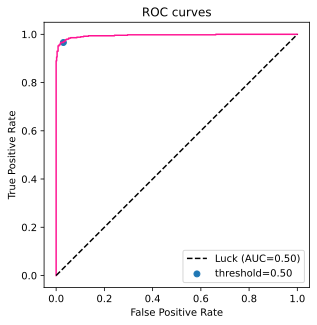

In [14]:
plt.plot(fpr, tpr, color="deeppink")
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
plt.scatter(fpr[index], tpr[index], label=f'threshold={thresholds[index]:.2f}')
plt.axis("square")
# plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

最后，我们对不同的信噪比进行了测试，绘制了不同信噪比下的ROC曲线，并计算了AUC值。

100%|██████████| 4/4 [02:41<00:00, 40.45s/it]


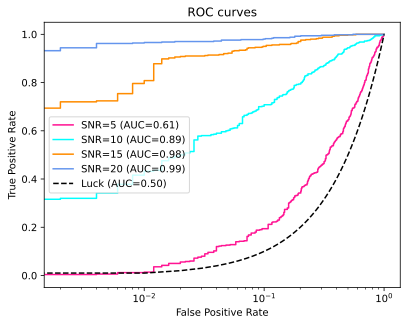

In [15]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

nsample_perepoch = 1000
snr_list = [5, 10, 15, 20]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, thresholds = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    plt.plot(fpr, tpr, color=next(colors), label=f'SNR={snr} (AUC={auc:.2f})')
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

在最后一部分，我们计算了ROC曲线的误差，并绘制了带有误差的ROC曲线。

这段代码展示了如何使用PyTorch进行二分类任务，并使用ROC曲线和AUC值进行模型评估。

同时，也展示了如何对不同的信噪比进行测试，以及如何计算和绘制带有误差的ROC曲线。

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:01<00:00, 40.60s/it]


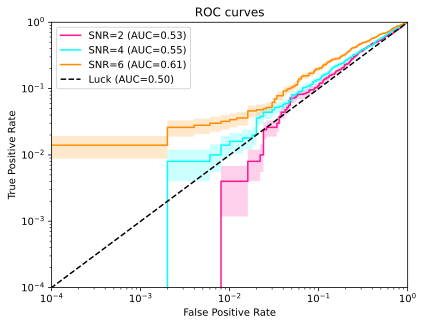

In [16]:
from itertools import cycle
colors = cycle(["deeppink", "aqua", "darkorange", "cornflowerblue"])

def sigma(n, tp):
    """

    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

nsample_perepoch = 1000
snr_list = [2, 4, 6]
for snr in tqdm(snr_list):
    dataset_test = DatasetGenerator(snr=snr, nsample_perepoch=nsample_perepoch, verbose=False)
    data_iter = DataLoader(dataset_test, batch_size=32, shuffle=True)
    y_hat_list, y_list = evaluate_gpu(net, data_iter, device)

    fpr, tpr, _ = roc_curve(y_list, y_hat_list)
    auc = roc_auc_score(y_list, y_hat_list)
    
    fpr_error = [sigma(len(y_list)/2., t) for t in fpr]
    tpr_error = [sigma(len(y_list)/2., t) for t in tpr]
    
    color = next(colors)
    plt.plot(fpr, tpr, color=color, label=f'SNR={snr} (AUC={auc:.2f})')
    plt.fill_between(fpr, tpr+tpr_error, tpr-tpr_error, alpha=0.2, facecolor=color, zorder=0)
plt.plot(*(np.linspace(0,1,100),)*2, 'k--', label='Luck (AUC=0.50)')
# plt.axis("square")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.xlim(1e-4,1)
plt.ylim(1e-4,1)
plt.legend()
plt.show()

In [ ]:
# !bash gen_test_data.sh

In [20]:
import lal
# import _pickle as pickle
import pickle
from tqdm import tqdm
from main import *
from utils import *

In [21]:
sizeofeach = 100
groud_truth = []
test_dataset = []

for snr in tqdm([2,4,5,6,7,8,9,10,15,20,25,30]):
    test_data_addr = f'BBH_testing_1s_8192Hz_10Ksamp_25n_iSNR{snr}_Hdet_astromass_1seed_ts_0.sav'
    with open(test_data_addr, 'rb') as rfp:
        data = pickle.load(rfp)
        index = np.random.randint(len(data[1]), size=sizeofeach)

        groud_truth.extend(data[1][index].tolist())
        test_dataset.append(np.expand_dims(data[0][index], 1))
groud_truth = np.asarray(groud_truth)
test_dataset = np.concatenate(test_dataset)

groud_truth.shape, test_dataset.shape

  0%|          | 0/12 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'BBH_testing_1s_8192Hz_10Ksamp_25n_iSNR2_Hdet_astromass_1seed_ts_0.sav'

In [ ]:
import pandas as pd
pd.Series(groud_truth).value_counts()

In [ ]:
import pandas as pd
pd.DataFrame({'id': range(len(groud_truth)),
              'Public': groud_truth,
              'Usage': ('Public',)*len(groud_truth)}).to_csv('ground_truth.csv', index=False)

In [ ]:
np.save('test', test_dataset)
# np.save('groud_truth', groud_truth)

# Submission

In [1]:
import lal
# import _pickle as pickle
import pickle
from tqdm import tqdm
from main import *
from utils import *

def evaluate_submissoin_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的预测结果"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device  # 获取设备信息
    softmax = nn.Softmax(dim=-1)  # 定义softmax函数，dim=-1表示在最后一个维度上进行softmax运算
    y_hat_list = []  # 初始化预测结果列表
    with torch.no_grad():  # 不进行梯度计算
        for X in data_iter:  # 遍历数据集
            X = X.to(device).to(torch.float)  # 将数据转移到设备上并转换为浮点型
            y_hat = net(X)  # 使用模型进行预测
            preds = softmax(y_hat).cpu().numpy()[:,1].tolist()  # 使用softmax函数处理预测结果，并转换为列表
            y_hat_list.extend(preds)  # 将预测结果添加到预测结果列表
    return y_hat_list


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
test_dataset = np.load('test.npy')
test_dataset.shape

(1200, 1, 2, 16384)

In [3]:
data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,)

In [4]:
# load model
device = torch.device('cuda')

# Where we output our model and loss history
checkpoint_dir = './checkpoints_cnn/'

# Creat model
net, epoch, train_loss_history = load_model(checkpoint_dir)
net.to(device);

Load network from checkpoints_cnn/model_e74.pt


In [5]:
results = evaluate_submissoin_gpu(net, data_loader, device)
len(results)

1200

In [7]:
# results

In [8]:
import pandas as pd
pd.DataFrame({'id': range(len(results)),
              'target': results}, index=None).to_csv('submission.csv', index=False)